<a href="https://colab.research.google.com/github/hkbu-kennycheng/comp3925/blob/main/lab6_Advanced_feature_fetching_and_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lab6 Advanced feature fetching and visualization 

Mounting Google Drive in Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!apt update
!apt install chromium-browser chromium-chromedriver fonts-noto fonts-noto-cjk
!pip install pyppeteer nest_asyncio pandas numpy tqdm seaborn
# for local runtime with anaconda, please comment out above code and use following conda install intead
# !pip install pyppeteer nest_asyncio pandas numpy tqdm seaborn

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:13 https://developer.

In [2]:
import asyncio
import nest_asyncio
from pyppeteer import launch
import pandas as pd

nest_asyncio.apply()

In [3]:
def runAndReturn(func):
  return asyncio.get_event_loop().run_until_complete(asyncio.gather(func))[0]

# Execrise answer

## Abouthai

In [4]:
from time import sleep

async def getAbouthai():
  data = []
  browser = await launch({'executablePath':'/usr/bin/chromium-browser', 'headless': True, 'args':['--no-sandbox']})
  # browser = await launch({'headless' :False}) # For local runtime
  page = await browser.newPage() # open a new browser window
  await page.setUserAgent('Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36')
  await page.setViewport({'width':1280, 'height':1024})
  await page.goto(f'https://www.abouthai.com/search', {'waitUntil':'networkidle0'}) # goto the urldow
  
  btnNext = await page.J('.layui-laypage-next')
  if btnNext == None:
    return data

  while True:
    await page.screenshot({'path':'aboutthai.png', 'fullPage':True}) # optinal: for progress monitoring
    for p in await page.JJ('.goodslist'):
      data.append({
        'name': await p.Jeval('.name .comcon', 'node => node.getAttribute("data-name")'),
        'brand': await p.Jeval('.name .comcon', 'node => node.getAttribute("data-brand")'),
        'category': await p.Jeval('.name .comcon', 'node => node.getAttribute("data-category")'),
        'subcat': await p.Jeval('.name .comcon', 'node => node.getAttribute("data-subcat")'),
        'price': await p.Jeval('.name .comcon', 'node => node.getAttribute("data-netprice")'),
        'stock': await p.Jeval('.name .comcon', 'node => node.getAttribute("data-stock")'),
        'photo': await p.Jeval('.photo img', 'node => node.getAttribute("data-original")')
      })
    btnNextDisabled = await page.J('.layui-laypage-next.layui-disabled')
    if not btnNextDisabled == None:
      break
    await page.Jeval('.layui-laypage-next', 'node => node.click()')
    sleep(5) # delay 5 second

  await browser.close() # close browser window
  return data

In [5]:
%%time

abouthai = runAndReturn(getAbouthai())

CPU times: user 12 s, sys: 1.34 s, total: 13.4 s
Wall time: 3min 45s


In [6]:
abouthaidf = pd.DataFrame(abouthai)
abouthaidf

,name,brand,category,subcat,price,stock,photo
0,Panbio 新冠病毒抗原快速檢測套裝 -4支裝 (泰國版),Abbott,健康用品,其他,380,PANBIO-4051892003569,https://www.abouthai.com/P1/stock_cover/PANBIO...
1,Panbio 新冠病毒抗原快速檢測 - 1支裝 (泰國版),Abbott,健康用品,其他,98,PANBIO-4051892003545,https://www.abouthai.com/P1/stock_cover/PANBIO...
2,阿布泰特級斑蘭燕窩(即食用) - 75毫升 x 4 樽,阿布泰,食品,燕窩,288,ABOUTHAI-8859589903330,https://www.abouthai.com/P1/stock_cover/ABOUTH...
3,癲噹 Din Dong x同舟三層掛耳式口罩 L 30片,UNITEMASK,寄售,口罩,89,UNITEMASK-4892985205626,https://www.abouthai.com/P1/stock_cover/UNITEM...
4,大大與小妹 X 同舟三層掛耳式口罩 粉紅色 L 30片,UNITEMASK,寄售,口罩,99,UNITEMASK-4892985203790,https://www.abouthai.com/P1/stock_cover/UNITEM...
...,...,...,...,...,...,...,...
740,Abouthai 100%純香薰精油 - 香茅 10ml,阿布泰,健康用品,香薰用精油,128,ABOUTHAI-8857103345031,https://www.abouthai.com/P1/stock_cover/ABOUTH...
741,Abouthai 100%純香薰精油 - 泰國青檸 30ml,阿布泰,健康用品,香薰用精油,258,ABOUTHAI-8857103345024,https://www.abouthai.com/P1/stock_cover/ABOUTH...
742,Abouthai 100%純香薰精油 - 泰國青檸 10ml,阿布泰,健康用品,香薰用精油,128,ABOUTHAI-8857103345017,https://www.abouthai.com/P1/stock_cover/ABOUTH...
743,Abouthai 陶瓷香薰機 - 白色 120ml,阿布泰,家居用品,香薰機,388,ABOUTHAI-8851648418557,https://www.abouthai.com/P1/stock_cover/ABOUTH...


In [8]:
abouthaidf['url'] = 'https://www.abouthai.com/product/' + abouthaidf['stock']
abouthaidf['url'].tolist()

['https://www.abouthai.com/product/PANBIO-4051892003569',
 'https://www.abouthai.com/product/PANBIO-4051892003545',
 'https://www.abouthai.com/product/ABOUTHAI-8859589903330',
 'https://www.abouthai.com/product/UNITEMASK-4892985205626',
 'https://www.abouthai.com/product/UNITEMASK-4892985203790',
 'https://www.abouthai.com/product/ABOUTHAI-8859589903378',
 'https://www.abouthai.com/product/ABOUTHAI-8859589903385',
 'https://www.abouthai.com/product/MAXOCEAN-8857124063211',
 'https://www.abouthai.com/product/MAMA-8851876001699',
 'https://www.abouthai.com/product/PRIK ME-231920181',
 'https://www.abouthai.com/product/NAIOUD-8852020910997',
 'https://www.abouthai.com/product/UDEE-8880045684289',
 'https://www.abouthai.com/product/UNITEMASK-4892985203912',
 'https://www.abouthai.com/product/LAYS-8850718816972',
 'https://www.abouthai.com/product/ARSENAL-8852052130608',
 'https://www.abouthai.com/product/VILAI-8859442800486',
 'https://www.abouthai.com/product/SUANMAMA-8859621200069',
 'ht

In [9]:
abouthaidf

,name,brand,category,subcat,price,stock,photo,url
0,Panbio 新冠病毒抗原快速檢測套裝 -4支裝 (泰國版),Abbott,健康用品,其他,380,PANBIO-4051892003569,https://www.abouthai.com/P1/stock_cover/PANBIO...,https://www.abouthai.com/product/PANBIO-405189...
1,Panbio 新冠病毒抗原快速檢測 - 1支裝 (泰國版),Abbott,健康用品,其他,98,PANBIO-4051892003545,https://www.abouthai.com/P1/stock_cover/PANBIO...,https://www.abouthai.com/product/PANBIO-405189...
2,阿布泰特級斑蘭燕窩(即食用) - 75毫升 x 4 樽,阿布泰,食品,燕窩,288,ABOUTHAI-8859589903330,https://www.abouthai.com/P1/stock_cover/ABOUTH...,https://www.abouthai.com/product/ABOUTHAI-8859...
3,癲噹 Din Dong x同舟三層掛耳式口罩 L 30片,UNITEMASK,寄售,口罩,89,UNITEMASK-4892985205626,https://www.abouthai.com/P1/stock_cover/UNITEM...,https://www.abouthai.com/product/UNITEMASK-489...
4,大大與小妹 X 同舟三層掛耳式口罩 粉紅色 L 30片,UNITEMASK,寄售,口罩,99,UNITEMASK-4892985203790,https://www.abouthai.com/P1/stock_cover/UNITEM...,https://www.abouthai.com/product/UNITEMASK-489...
...,...,...,...,...,...,...,...,...
740,Abouthai 100%純香薰精油 - 香茅 10ml,阿布泰,健康用品,香薰用精油,128,ABOUTHAI-8857103345031,https://www.abouthai.com/P1/stock_cover/ABOUTH...,https://www.abouthai.com/product/ABOUTHAI-8857...
741,Abouthai 100%純香薰精油 - 泰國青檸 30ml,阿布泰,健康用品,香薰用精油,258,ABOUTHAI-8857103345024,https://www.abouthai.com/P1/stock_cover/ABOUTH...,https://www.abouthai.com/product/ABOUTHAI-8857...
742,Abouthai 100%純香薰精油 - 泰國青檸 10ml,阿布泰,健康用品,香薰用精油,128,ABOUTHAI-8857103345017,https://www.abouthai.com/P1/stock_cover/ABOUTH...,https://www.abouthai.com/product/ABOUTHAI-8857...
743,Abouthai 陶瓷香薰機 - 白色 120ml,阿布泰,家居用品,香薰機,388,ABOUTHAI-8851648418557,https://www.abouthai.com/P1/stock_cover/ABOUTH...,https://www.abouthai.com/product/ABOUTHAI-8851...


## Broadway

In [16]:
from time import sleep

async def getBroadway():
  data = []
  browser = await launch({'executablePath':'/usr/bin/chromium-browser', 'headless': True, 'args':['--no-sandbox']})
  # browser = await launch({'headless' :False})
  page = await browser.newPage() # open a new browser window
  await page.setUserAgent('Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36')
  await page.setViewport({'width':1280, 'height':1024})
  await page.goto(f'https://www.broadwaylifestyle.com/hk_en/catalogsearch/result/?q=__empty__', {'waitUntil':'networkidle0'}) # goto the urldow

  sleep(5) # wait for 5 second
  await page.screenshot({'path':'broadwaystart.png'})

  try:
    popupClose = await page.waitForSelector('.startup-popup-wrapper .action-close')
    await popupClose.click()
  except:
    pass

  while True:
    await page.waitForSelector('.ais-Pagination-item--nextPage')
    await page.screenshot({'path':'broadway.png', 'fullPage':True})

    for p in await page.JJ('.ais-Hits-item'):
      await p.focus()
      await page.waitForSelector('.ais-Hits-item meta[itemprop="price"]')
      data.append({
        'name': await p.Jeval('.product-item-name', 'node => node.textContent'),
        'brand': await p.Jeval('.product-item-brand', 'node => node.textContent'),
        'price': await p.Jeval('.price-box.after_special', 'node => node.textContent'),
        'url':await p.Jeval('a.result', 'node => node.getAttribute("href")'),
        'img':await p.Jeval('a.result img', 'node => node.getAttribute("src")'),
      })
        
    btnNextDisabled = await page.J('.ais-Pagination-item--nextPage.ais-Pagination-item--disabled') #done
    if not btnNextDisabled == None:
      break
    next = await page.J('.ais-Pagination-item--nextPage')
    await next.focus()
    await next.click()

  await browser.close() # close browser window
  return data

In [17]:
%%time

broadway = runAndReturn(getBroadway())

CPU times: user 20.4 s, sys: 2.16 s, total: 22.6 s
Wall time: 2min 31s


In [18]:
broadwaydf = pd.DataFrame(broadway)
broadwaydf

,name,brand,price,url,img
0,V20M 20 BOT Wine Cellar,VIVANT,"HK$1,730.00",https://www.broadwaylifestyle.com/hk_en/vivant...,https://www.broadwaylifestyle.com/media/catalo...
1,PuriCare H13 HEPA Filter,LG,HK$98.00,https://www.broadwaylifestyle.com/hk_en/lg-pur...,https://www.broadwaylifestyle.com/media/catalo...
2,PuriCare™ AP551AWFA Wearable Air Purifier,LG,"HK$1,480.00",https://www.broadwaylifestyle.com/hk_en/lg-pur...,https://www.broadwaylifestyle.com/media/catalo...
3,PuriCare Inner Cover,LG,HK$98.00,https://www.broadwaylifestyle.com/hk_en/lg-pur...,https://www.broadwaylifestyle.com/media/catalo...
4,WF-XB700 TRUE WIRELESS EARPHONE,SONY,HK$799.00,https://www.broadwaylifestyle.com/hk_en/sony-w...,https://www.broadwaylifestyle.com/media/catalo...
...,...,...,...,...,...
995,Beoplay HX ANC Headphones,B&O PLAY,"HK$3,998.00",https://www.broadwaylifestyle.com/hk_en/b-o-pl...,https://www.broadwaylifestyle.com/media/catalo...
996,"X24ih (13L82AA) 23.8"" FHD GAMING MONITOR",HP,"HK$2,399.00",https://www.broadwaylifestyle.com/hk_en/hp-x24...,https://www.broadwaylifestyle.com/media/catalo...
997,XF 18mm F/1.4 R LM PRIME LENS,FUJIFILM,"HK$7,800.00",https://www.broadwaylifestyle.com/hk_en/fujifi...,https://www.broadwaylifestyle.com/media/catalo...
998,Omron JPN610T Upper Arm Blood Pressure Monitor,OMRON,"HK$1,206.00",https://www.broadwaylifestyle.com/hk_en/omron-...,https://www.broadwaylifestyle.com/media/catalo...


# Revist ParkNShop with `pyppeteer`


In [19]:
from time import sleep

async def getPnKWithKeyword(keyword):
  data = []
  perPage = 100
  browser = await launch({'executablePath':'/usr/bin/chromium-browser', 'headless': True, 'args':['--no-sandbox']}) # For Google Colab
  #browser = await launch({'headless':False}) # For loacl runtime
  page = await browser.newPage() # open a new browser window
  await page.setUserAgent('Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36')
  await page.setViewport({'width':1280, 'height':1024})
  await page.goto(f'https://www.parknshop.com/en/search?code=ALL&text={keyword}&searchField={keyword}&resultsForPage={perPage}') # goto the urldow
  await page.waitForSelector('.showMore', {'visible':True})
  await page.screenshot({'path':'PnK.png', 'fullPage':True})

  total = int(await page.Jeval('[data-product_list_total_items]','node => node.getAttribute("data-product_list_total_items")'))
  i = 1
  while True:
    print(f'loop {keyword} show more {i}/{total//perPage}')
    showMore = await page.waitForSelector('.showMore', {'visible':True})
    await showMore.focus()
    await page.Jeval('.showMore a','node => node.click()')
    await page.waitForSelector('.isloading-overlay', {'timeout':0,'hidden':True})
    # sleep(1)
    showMore = await page.J('.showMore')
    if showMore == None or await showMore.boxModel() == None:
      break
    await showMore.screenshot({'path':'showmore.png'})
    i += 1
    if i > 40:
      break
  await page.screenshot({'path':f'{keyword}.png','fullPage':True})
  for p in await page.JJ('.product-container > .item'):
    # print('loop products')
    await p.hover()
    data.append({
      'name':await p.Jeval('.homeProductCarousel', 'node => node.getAttribute("data-gtm-homeproductcarousel-name")'),
      'id':''.join(await p.JJeval('.homeProductCarousel', 'nodes => nodes.map(node => node.getAttribute("data-gtm-homeproductcarousel-id"))')),
      'url':'https://www.parknshop.com'+await p.Jeval('.pic > a', 'node => node.getAttribute("data-link")'),
      'pic':'https://www.parknshop.com'+await p.Jeval('.pic > a > img', 'node => node.getAttribute("data-original")'),
      'price':await p.Jeval('.homeProductCarousel', 'node => node.getAttribute("data-gtm-homeproductcarousel-price")'),
      'specialoffer':''.join(await p.JJeval('.special-offer', 'nodes => nodes.map(node => node.textContent)')),
      'brand':await p.Jeval('.homeProductCarousel', 'node => node.getAttribute("data-gtm-homeproductcarousel-brand")'),
      'category':await p.Jeval('.homeProductCarousel', 'node => node.getAttribute("data-gtm-homeproductcarousel-category")'),
      'variant':await p.Jeval('.homeProductCarousel', 'node => node.getAttribute("data-gtm-homeproductcarousel-variant")'),
      'variantname':await p.Jeval('.homeProductCarousel', 'node => node.getAttribute("data-gtm-homeproductcarousel-variant_name")'),
      'topseller':len(await p.JJ('.topSeller')) == 1,
      'fairtrade':len(await p.JJ('.fairTrade')) == 1,
      'organic':len(await p.JJ('.organic')) == 1,
      'eshoponly':len(await p.JJ('.eShopOnly')) == 1,
      'healthyfat':len(await p.JJ('.healthyFat')) == 1,
      'crustacean':len(await p.JJ('.crustacean')) == 1,
    })
  await browser.close()
  return data

In [ ]:
%%time

coffeedf = pd.DataFrame(runAndReturn(getPnKWithKeyword('coffee')))

loop coffee show more 1/2
loop coffee show more 2/2
CPU times: user 18.6 s, sys: 1.59 s, total: 20.2 s
Wall time: 1min 57s


In [ ]:
coffeedf

,name,id,url,pic,price,specialoffer,brand,category,variant,variantname,topseller,fairtrade,organic,eshoponly,healthyfat,crustacean
0,Instant Coffee,490639,https://www.parknshop.com/en/instant-coffee/p/...,https://www.parknshop.com/medias/sys_master/fr...,25.7,,SELECT,Instant & Ground Coffee,490639,200G,False,False,False,False,False,False
1,Coffee Sugar,420785,https://www.parknshop.com/en/coffee-sugar/p/BP...,https://www.parknshop.com/medias/sys_master/fr...,25.5,,SELECT,Sugar & Sweeteners,420785,1KG,False,False,False,False,False,False
2,Coffee Creamer,490643,https://www.parknshop.com/en/coffee-creamer/p/...,https://www.parknshop.com/medias/sys_master/fr...,49.9,,SELECT,Instant & Ground Coffee,490643,800G,False,False,False,False,False,False
3,Gold Instant Coffee,490642,https://www.parknshop.com/en/gold-instant-coff...,https://www.parknshop.com/medias/sys_master/fr...,39.9,,SELECT,Instant & Ground Coffee,490642,100G,True,False,False,False,False,False
4,Gold Instant Coffee,490641,https://www.parknshop.com/en/gold-instant-coff...,https://www.parknshop.com/medias/sys_master/fr...,83.9,,SELECT,Instant & Ground Coffee,490641,200G,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,Starbucks® Toffee Nut Latte By Nescafé® Dolce ...,413550,https://www.parknshop.com/en/toffee-nut-latte-...,https://www.parknshop.com/medias/sys_master/fr...,62.5,,STARBUCKS,Instant & Ground Coffee,413550,6'S,True,False,False,False,False,False
287,Starbucks® Holiday Blend By Nespresso,453176,https://www.parknshop.com/en/holiday-blend-by-...,https://www.parknshop.com/medias/sys_master/fr...,49,,STARBUCKS,Instant & Ground Coffee,453176,57G,False,False,False,False,False,False
288,Ncc - Deciso,494484,https://www.parknshop.com/en/ncc-deciso/p/BP_4...,https://www.parknshop.com/medias/sys_master/fr...,47,,LAVAZZA,Instant & Ground Coffee,494484,50G,False,False,False,False,False,False
289,Barista Oat Drink,340671,https://www.parknshop.com/en/barista-oat-drink...,https://www.parknshop.com/medias/sys_master/fr...,36.9,,,Milk & Yogurt Drinks,340671,1L,True,False,False,False,False,False


In [ ]:
%%time
for c in '0123456789':
  pd.DataFrame(runAndReturn(getPnKWithKeyword(c))).to_csv(f'/content/drive/MyDrive/pnk{c}.csv')

# Loading dataset

In [20]:
!curl https://gist.githubusercontent.com/hkbu-kennycheng/6e20e5965916e85008701f16e8e41a29/raw/199efc8496594a3539ed26f52ddfb774d8e5c0c1/pnk0.csv > pnk0.csv
!curl https://gist.githubusercontent.com/hkbu-kennycheng/36e05f717c4720fcecc45ddcf613639b/raw/74bebec8fe652f91b360fdc9bc26ba84d6209f8c/pnk1.csv > pnk1.csv
!curl https://gist.githubusercontent.com/hkbu-kennycheng/776469f16450995ac4f4279f9b382949/raw/ef4b582abb61ddda09788d997c2c2a2b32e6462e/pnk2.csv > pnk2.csv
!curl https://gist.githubusercontent.com/hkbu-kennycheng/46c0cbc4cfc2dc55c5c6b62125fa3dd9/raw/457719baf2555bb463ac878ae586d8062f9f5bd5/pnk3.csv > pnk3.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1022k  100 1022k    0     0  3145k      0 --:--:-- --:--:-- --:--:-- 3145k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1039k  100 1039k    0     0  3443k      0 --:--:-- --:--:-- --:--:-- 3432k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1030k  100 1030k    0     0  3630k      0 --:--:-- --:--:-- --:--:-- 3630k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1035k  100 1035k    0     0  4794k      0 --:--:-- --:--:-- --:--:-- 4794k


In [21]:
import pandas as pd

df = pd.read_csv('pnk0.csv', index_col=0)
df = df.append(pd.read_csv('pnk1.csv', index_col=0), ignore_index=True)
df = df.append(pd.read_csv('pnk2.csv', index_col=0), ignore_index=True)
df = df.append(pd.read_csv('pnk3.csv', index_col=0), ignore_index=True)

df

,name,id,url,pic,price,specialoffer,brand,category,variant,variantname,topseller,fairtrade,organic,eshoponly,healthyfat,crustacean
0,Alkaline Water 9.0 (random Pick),499585,https://www.parknshop.com/en/alkaline-water-9-...,https://www.parknshop.com/medias/sys_master/fr...,9.0,NaN,WATSONS,Water,499585,420ML,False,False,False,False,False,False
1,Alkaline Water 9.0 (case) (420ml X 24 Bottles),378829,https://www.parknshop.com/en/alkaline-water-9-...,https://www.parknshop.com/medias/sys_master/fr...,168.0,NaN,WATSONS,"Water,Bottled Water",378829,24X420ML,False,False,False,False,False,False
2,L Type Interdental Brush 0.6mm - 6pcs,805629,https://www.parknshop.com/en/l-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,13.9,\n\t\t\t\t\t\t$20.8 / 2pcs\n\t\t\t\t\t\t,WATSONS-,Dental Accessories & Denture,805629,6S,False,False,False,False,False,False
3,L Type Interdental Brush 0.8mm 6pcs,805630,https://www.parknshop.com/en/l-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,13.9,\n\t\t\t\t\t\t$20.8 / 2pcs\n\t\t\t\t\t\t,WATSONS-,Dental Accessories & Denture,805630,6S,True,False,False,False,False,False
4,I Type Interdental Brush 0.7mm 5pcs,805627,https://www.parknshop.com/en/i-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,10.0,\n\t\t\t\t\t\t$15.0 / 2pcs\n\t\t\t\t\t\t,WATSONS-,Dental Accessories & Denture,805627,5S,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16395,Lychee In Syrup,125947,https://www.parknshop.com/en/lychee-in-syrup/p...,https://www.parknshop.com/medias/sys_master/fr...,33.9,NaN,TWIN ELEPHANTS,Fruits,125947,565G,False,False,False,False,False,False
16396,Knax,336140,https://www.parknshop.com/en/knax/p/BP_336140,https://www.parknshop.com/medias/sys_master/fr...,45.9,NaN,HENGSTENBERG,Pickles,336140,720ML,False,False,False,False,False,False
16397,Multi-use Tong 12inch,197685,https://www.parknshop.com/en/multi-use-tong-12...,https://www.parknshop.com/medias/sys_master/fr...,19.5,NaN,DIAMOND,BBQ,197685,UNIT,False,False,False,False,False,False
16398,Apple Blackcurrant Mini Pack,136236,https://www.parknshop.com/en/apple-blackcurran...,https://www.parknshop.com/medias/sys_master/fr...,27.9,NaN,GOLDEN CIRCLE,Juice & Cordials,136236,150MLX6,True,False,False,False,False,False


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16400 entries, 0 to 16399
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16378 non-null  object 
 1   id            16400 non-null  int64  
 2   url           16400 non-null  object 
 3   pic           16400 non-null  object 
 4   price         16399 non-null  float64
 5   specialoffer  5324 non-null   object 
 6   brand         16189 non-null  object 
 7   category      14586 non-null  object 
 8   variant       16400 non-null  int64  
 9   variantname   16398 non-null  object 
 10  topseller     16400 non-null  bool   
 11  fairtrade     16400 non-null  bool   
 12  organic       16400 non-null  bool   
 13  eshoponly     16400 non-null  bool   
 14  healthyfat    16400 non-null  bool   
 15  crustacean    16400 non-null  bool   
dtypes: bool(6), float64(1), int64(2), object(7)
memory usage: 1.3+ MB


# Data cleaning

Cleaning empty space characters with strip for object columns

In [24]:
df['name'] = df['name'].str.strip()
df['url'] = df['url'].str.strip()
df['pic'] = df['pic'].str.strip()
df['specialoffer'] = df['specialoffer'].str.strip()
df['brand'] = df['brand'].str.strip()
df['category'] = df['category'].str.strip()
df['variantname'] = df['variantname'].str.strip()

df

,name,id,url,pic,price,specialoffer,brand,category,variant,variantname,topseller,fairtrade,organic,eshoponly,healthyfat,crustacean
0,Alkaline Water 9.0 (random Pick),499585,https://www.parknshop.com/en/alkaline-water-9-...,https://www.parknshop.com/medias/sys_master/fr...,9.0,NaN,WATSONS,Water,499585,420ML,False,False,False,False,False,False
1,Alkaline Water 9.0 (case) (420ml X 24 Bottles),378829,https://www.parknshop.com/en/alkaline-water-9-...,https://www.parknshop.com/medias/sys_master/fr...,168.0,NaN,WATSONS,"Water,Bottled Water",378829,24X420ML,False,False,False,False,False,False
2,L Type Interdental Brush 0.6mm - 6pcs,805629,https://www.parknshop.com/en/l-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,13.9,$20.8 / 2pcs,WATSONS-,Dental Accessories & Denture,805629,6S,False,False,False,False,False,False
3,L Type Interdental Brush 0.8mm 6pcs,805630,https://www.parknshop.com/en/l-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,13.9,$20.8 / 2pcs,WATSONS-,Dental Accessories & Denture,805630,6S,True,False,False,False,False,False
4,I Type Interdental Brush 0.7mm 5pcs,805627,https://www.parknshop.com/en/i-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,10.0,$15.0 / 2pcs,WATSONS-,Dental Accessories & Denture,805627,5S,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16395,Lychee In Syrup,125947,https://www.parknshop.com/en/lychee-in-syrup/p...,https://www.parknshop.com/medias/sys_master/fr...,33.9,NaN,TWIN ELEPHANTS,Fruits,125947,565G,False,False,False,False,False,False
16396,Knax,336140,https://www.parknshop.com/en/knax/p/BP_336140,https://www.parknshop.com/medias/sys_master/fr...,45.9,NaN,HENGSTENBERG,Pickles,336140,720ML,False,False,False,False,False,False
16397,Multi-use Tong 12inch,197685,https://www.parknshop.com/en/multi-use-tong-12...,https://www.parknshop.com/medias/sys_master/fr...,19.5,NaN,DIAMOND,BBQ,197685,UNIT,False,False,False,False,False,False
16398,Apple Blackcurrant Mini Pack,136236,https://www.parknshop.com/en/apple-blackcurran...,https://www.parknshop.com/medias/sys_master/fr...,27.9,NaN,GOLDEN CIRCLE,Juice & Cordials,136236,150MLX6,True,False,False,False,False,False


Check for dash in `df['brand']`

In [25]:
df[df['brand'].str.count('-') > 0]['brand'].describe()

count         391
unique         22
top       DE-MA-E
freq          138
Name: brand, dtype: object

replace dash with empty string in `df['brand']`

In [26]:
df['brand'] = df['brand'].str.replace('-','')
df['brand'].describe()

count      16189
unique      1360
top       SELECT
freq        1232
Name: brand, dtype: object

# Advanced feature fetching

## Fetch product detail by product URL

In [29]:
async def getPnKProductDetail(url):
  data = []
  browser = await launch({'executablePath':'/usr/bin/chromium-browser', 'headless': True, 'args':['--no-sandbox']}) # For Google Colab
  #browser = await launch({'headless':False}) # For loacl runtime
  page = await browser.newPage() # open a new browser window
  await page.setUserAgent('Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36')
  await page.setViewport({'width':1280, 'height':1024})
  await page.goto(url) # goto the urldow
  await page.waitForSelector('.product-info h3, .product-info h3 ~ p', {'visible':True})

  dataPairs = await page.JJeval('.product-info h3, .product-info h3 ~ p', 'nodes => nodes.map(node => node.textContent)')
  await browser.close()
  return [{
      dataPairs[i].strip().replace(':','') : dataPairs[i+1].strip()
    } for i in range(0, len(dataPairs), 2)
    if len(dataPairs[i].strip()) > 0 and len(dataPairs[i+1].strip()) > 0]

In [28]:
print(list(range(0, 10, 2)))

[0, 2, 4, 6, 8]


In [30]:
def fetchDetail(url):
  pairs = runAndReturn(getPnKProductDetail(url))
  result = {'url':url}
  for p in pairs:
    result.update(p)
  return pd.Series(result)

In [31]:
df['url'].describe()

count                                                 16400
unique                                                 6083
top       https://www.parknshop.com/en/strawberry-jam/p/...
freq                                                      8
Name: url, dtype: object

In [32]:
%%time

urldf = df['url'].iloc[:10].apply(fetchDetail)

CPU times: user 2.81 s, sys: 324 ms, total: 3.14 s
Wall time: 35.5 s


In [33]:
urldf

,url,Product Details,Origin,Product Warnings,Product Usage,Storage Condition,Ingredients
0,https://www.parknshop.com/en/alkaline-water-9-...,- Smart way to hydrate your body- Helps to neu...,Hong Kong,This product contains minerals and is electrol...,Consume shortly after opening.,Keep in a cool dry place away from direct sunl...,"Water, Ocean Mineral Concentrate"
1,https://www.parknshop.com/en/alkaline-water-9-...,- Helps neutralize acidity-Help the body detox...,Hong Kong,Keep in a cool dry place away from direct sunl...,drink,Keep in a cool dry place away from direct sunl...,"Water, Ocean Mineral Concentrate"
2,https://www.parknshop.com/en/l-type-interdenta...,WATSONS ORAL CARE RANGE IS SPECIALLY DESIGNED ...,China,Do not force the interdental brush between tee...,1. PUT THE INTERDENTAL BRUSH BETWEEN THE TEETH...,"STORE IN A COOL, DRY PLACE AWAY FROM DIRECT SU...",NaN
3,https://www.parknshop.com/en/l-type-interdenta...,WATSONS ORAL CARE RANGE IS SPECIALLY DESIGNED ...,China,Do not force the interdental brush between tee...,1. PUT THE INTERDENTAL BRUSH BETWEEN THE TEETH...,"STORE IN A COOL, DRY PLACE AWAY FROM DIRECT SU...",NaN
4,https://www.parknshop.com/en/i-type-interdenta...,WATSONS ORAL CARE RANGE IS SPECIALLY DESIGNED ...,China,Do not force the interdental brush between tee...,1. PUT THE INTERDENTAL BRUSH BETWEEN THE TEETH...,"STORE IN A COOL, DRY PLACE AWAY FROM DIRECT SU...",NaN
5,https://www.parknshop.com/en/alkaline-water-9-...,NaN,Hong Kong,NaN,NaN,NaN,NaN
6,https://www.parknshop.com/en/alkaline-water-9-...,NaN,Hong Kong,Keep in a cool dry place away from direct sunl...,NaN,Keep in a cool dry place away from direct sunl...,"Water, Ocean Mineral Concentrate"
7,https://www.parknshop.com/en/l-type-interdenta...,NaN,China,NaN,NaN,NaN,NaN
8,https://www.parknshop.com/en/i-type-interdenta...,NaN,China,NaN,NaN,NaN,NaN
9,https://www.parknshop.com/en/shibainc-mos-repe...,Long lasting protection contains citronella oil,China,NaN,NaN,"Keep in cool and dry place, avoid direct sunli...",NaN


## Merging details to orignal data frame with `pd.merge`

![](https://url2img-web.herokuapp.com/aHR0cHM6Ly9wYW5kYXMucHlkYXRhLm9yZy9wYW5kYXMtZG9jcy9zdGFibGUvcmVmZXJlbmNlL2FwaS9wYW5kYXMubWVyZ2UuaHRtbA==)

how{‘left’, ‘right’, ‘outer’, ‘inner’, ‘cross’}, default ‘inner’ Type of merge to be performed.

- left: use only keys from left frame, similar to a SQL left outer join; preserve key order.
- right: use only keys from right frame, similar to a SQL right outer join; preserve key order.
- outer: use union of keys from both frames, similar to a SQL full outer join; sort keys lexicographically.
- inner: use intersection of keys from both frames, similar to a SQL inner join; preserve the order of the left keys.
- cross: creates the cartesian product from both frames, preserves the order of the left keys.

In [34]:
df = pd.merge(df, urldf, on='url', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16400 entries, 0 to 16399
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               16378 non-null  object 
 1   id                 16400 non-null  int64  
 2   url                16400 non-null  object 
 3   pic                16400 non-null  object 
 4   price              16399 non-null  float64
 5   specialoffer       5324 non-null   object 
 6   brand              16189 non-null  object 
 7   category           14586 non-null  object 
 8   variant            16400 non-null  int64  
 9   variantname        16398 non-null  object 
 10  topseller          16400 non-null  bool   
 11  fairtrade          16400 non-null  bool   
 12  organic            16400 non-null  bool   
 13  eshoponly          16400 non-null  bool   
 14  healthyfat         16400 non-null  bool   
 15  crustacean         16400 non-null  bool   
 16  Product Details    12 

In [ ]:
df['Product Details'].describe()

count                                                  12
unique                                                  4
top       Long lasting protection contains citronella oil
freq                                                    7
Name: Product Details, dtype: object

In [ ]:
df['Origin'].describe()

count        20
unique        2
top       China
freq         12
Name: Origin, dtype: object

In [ ]:
df['Product Warnings'].describe()

count                                                    10
unique                                                    3
top       Keep in a cool dry place away from direct sunl...
freq                                                      6
Name: Product Warnings, dtype: object

In [ ]:
df['Product Usage'].describe()

count                                                     5
unique                                                    3
top       1. PUT THE INTERDENTAL BRUSH BETWEEN THE TEETH...
freq                                                      3
Name: Product Usage, dtype: object

In [ ]:
df['Storage Condition'].describe()

count                                                    17
unique                                                    3
top       Keep in a cool dry place away from direct sunl...
freq                                                      7
Name: Storage Condition, dtype: object

In [ ]:
df['Ingredients'].describe()

count                                    7
unique                                   1
top       Water, Ocean Mineral Concentrate
freq                                     7
Name: Ingredients, dtype: object

# Advanced visualization for geographical data

We will use `folium` to show geographical data using an interactive map.

In [35]:
!pip install folium
# !conda install folium

import folium

     |████████████████████████████████| 127 kB 13.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.8
    Uninstalling urllib3-1.26.8:
      Successfully uninstalled urllib3-1.26.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Create a map with `folium.Map` and display it.

In [36]:
map = folium.Map(location=[22.3193, 114.1694])
map

In [44]:
# We can set the initial zoom level
map = folium.Map(location=[22.3393, 114.1824], zoom_start=18) # ranging form 1 to 18
map

In [53]:
# We could also add some markers 
map = folium.Map(location=[22.3383, 114.1824], zoom_start=18)

folium.Marker(
    location=[22.338736103814473, 114.18203111076629],
    popup='Shaw Tower',
    icon=folium.Icon(color="blue")
).add_to(map)

folium.CircleMarker(
    location=[22.33783591997964, 114.18282723535445],
    radius=100,
    popup="Joint Sports Center",
    color="#3186cc",
    fill=True,
    fill_color="#3186cc",
).add_to(map)

map

In [64]:
district = 'https://www.had.gov.hk/psi/hong-kong-administrative-boundaries/hksar_18_district_boundary.json'

## District polygon data for Hong Kong

![](https://url2img-web.herokuapp.com/aHR0cHM6Ly93d3cuaGFkLmdvdi5oay9wc2kvaG9uZy1rb25nLWFkbWluaXN0cmF0aXZlLWJvdW5kYXJpZXMvaGtzYXJfMThfZGlzdHJpY3RfYm91bmRhcnkuanNvbg==)

## Number of Escalators in Hong Kong

In [54]:
!curl https://www.emsd.gov.hk/filemanager/en/content_808/dataset/age_distribution_escalator.csv > age_distribution_escalator.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6147  100  6147    0     0   7890      0 --:--:-- --:--:-- --:--:--  7880


In [55]:
escalators = pd.read_csv('age_distribution_escalator.csv')
escalators

,District (English),District (Traditional Chinese),Age Range,Number of Escalators
0,CENTRAL AND WESTERN,中西區,01. <=5,59
1,CENTRAL AND WESTERN,中西區,02. 6-10,103
2,CENTRAL AND WESTERN,中西區,03. 11-15,54
3,CENTRAL AND WESTERN,中西區,04. 16-20,158
4,CENTRAL AND WESTERN,中西區,05. 21-30,333
...,...,...,...,...
139,YUEN LONG,元朗區,04. 16-20,113
140,YUEN LONG,元朗區,05. 21-30,65
141,YUEN LONG,元朗區,06. 31-40,34
142,YUEN LONG,元朗區,07. 41-50,2


Summing up number by district

In [ ]:
#escalators[['District (English)', 'Number of Escalators']].groupby(['District (English)'], as_index=False).sum(['Number of Escalators'])

In [58]:
districtescalators = escalators[['District (English)', 'Number of Escalators']].groupby(['District (English)'], as_index=False).sum(['Number of Escalators'])
districtescalators

,District (English),Number of Escalators
0,CENTRAL AND WESTERN,1136
1,EASTERN,675
2,ISLANDS,416
3,KOWLOON CITY,566
4,KWAI TSING,314
5,KWUN TONG,767
6,NORTH,177
7,SAI KUNG,387
8,SHA TIN,561
9,SHAM SHUI PO,420


In [59]:
districtescalators['District (English)'].str.replace('CENTRAL AND WESTERN', 'CENTRAL & WESTERN')

0     CENTRAL & WESTERN
1               EASTERN
2               ISLANDS
3          KOWLOON CITY
4            KWAI TSING
5             KWUN TONG
6                 NORTH
7              SAI KUNG
8               SHA TIN
9          SHAM SHUI PO
10             SOUTHERN
11               TAI PO
12            TSUEN WAN
13             TUEN MUN
14             WAN CHAI
15         WONG TAI SIN
16        YAU TSIM MONG
17            YUEN LONG
Name: District (English), dtype: object

Transform first character to upper case in each word in order to match with the district JSON data.

In [73]:
help(str.capitalize)

Help on method_descriptor:

capitalize(self, /)
    Return a capitalized version of the string.
    
    More specifically, make the first character have upper case and the rest lower
    case.



In [60]:
def ucfirst(str):
  return ' '.join([w.capitalize() for w in str.split(' ')])

In [75]:
ucfirst('YAU TSIM MONG')

# ['YAU', 'TSIM', 'MONG']
# for w in ['YAU', 'TSIM', 'MONG']:
#   print(w.capitalize())

# after [w.capitalize() for w in str.split(' ')], it would becomes:
# ['Yau', 'Tsim', 'Mong']

' '.join(['Yau', 'Tsim', 'Mong'])

'Yau Tsim Mong'

In [62]:
districtescalators['District (English)'] = districtescalators['District (English)'].str.replace('CENTRAL AND WESTERN', 'CENTRAL & WESTERN').apply(ucfirst)
districtescalators

,District (English),Number of Escalators
0,Central & Western,1136
1,Eastern,675
2,Islands,416
3,Kowloon City,566
4,Kwai Tsing,314
5,Kwun Tong,767
6,North,177
7,Sai Kung,387
8,Sha Tin,561
9,Sham Shui Po,420


Let's take a look for the distribution using histogram

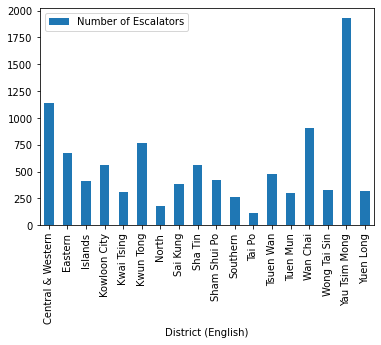

In [63]:
districtescalators.plot.bar(x='District (English)', y='Number of Escalators')

## Build the map and adding a layer to visualize the data

In [72]:
# reset the map
map_hk = folium.Map(location=[22.3383, 114.1824], zoom_start=10)

# We can create a Choropleth map by creating the following object
folium.Choropleth(
    geo_data=district,  # A GeoJSON file for the HK
    name="Escalators distribution",  # The name of this layer.
    data=districtescalators,  # The DataFrame object
    columns=['District (English)', 'Number of Escalators'],  # columns of the DataFrame to work on
    key_on="feature.properties.District",  # Variable in the `geo_data` GeoJSON file
    fill_color="Set2", # Color schema
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Escalators",
).add_to(map_hk)

folium.LayerControl().add_to(map_hk)

map_hk

### List of color schemes

https://github.com/python-visualization/folium/blob/a911d2f7b074eba05dad9facc84c3404fb9c3d54/folium/utilities.py#L112

![](https://url2img-web.herokuapp.com/aHR0cHM6Ly9naXRodWIuY29tL3B5dGhvbi12aXN1YWxpemF0aW9uL2ZvbGl1bS9ibG9iL2E5MTFkMmY3YjA3NGViYTA1ZGFkOWZhY2M4NGMzNDA0ZmI5YzNkNTQvZm9saXVtL3V0aWxpdGllcy5weSNMMTEy)